## TLDR;

- Linear regression on itself is not performant for longer time-scales
- Most systems have some capabilities for linear regression built-in
- Adding dummy variables for datetime features(i.e. months, weekday etc.) adds predictive power

## Introduction

Most of the time ordinary linear regression is seen as a beginners model that is not particularly useful, and most of the time it is discarded and replaced by a shiny neural net or a fancy gradient-boosted model, but actually linear regression can be used to determine the (linear) relationship between a dependent and one or more independent variables. the direction and magnitude can also be estimated with the help of linear regression. This model type is used in many fields including but not limited to Economics, Finance, Social science, etc. The popularity of this model is model is likely due to the fact that most systems have built-in functionality that enables the training of linear models, they are also very cheap/fast to train, and one can also determine that the model has optimal parameters. all these features make linear regression an excellent model to start with. 

To extend the capabilities of the linear model for time series forecasting, dummy variables can be utilized. These dummies can provide additional information about the relationship over time, can help the model to identify seasonality over time and also gauge the effect of one-off events, examples are price reductions or natural disasters. 

For instance we can create a dummy to identify whether a particular day is a weekday or a weekend. These can also be applied to the months, the week of year, etc.


## Imports


In [29]:
# | echo: false
# | output: false

# importing the black formatter
# and auto format cell before execution
import jupyter_black

jupyter_black.load(lab=False)

first we import all the libraries, the default data science stuff and the sklearn for the linear model 

In [30]:
# | code-fold: show

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [31]:
# | echo: false
# | output: false
sns.set_style("darkgrid")

In [32]:
# | echo: false
# | output: false
# setting picture output params

fig_height = 4.0
fig_width = fig_height * 1.618
plt.rcParams["figure.figsize"] = [fig_width, fig_height]
plt.rcParams["figure.dpi"] = 256

## Reading in the data

For this example we will be using a dataset form the prophet package. I have selected this one because in the prophet documentation this dataset is used in the section "Seasonality, Holiday Effects, And Regressors" so it seems fitting to use it. 
The prophet [docs](https://facebook.github.io/prophet/docs/quick_start.html) describe the dataset in the following way:

> As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. We scraped this data using the Wikipedia trend package in R. Peyton Manning provides a nice example because it illustrates some of Prophet’s features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning’s playoff and superbowl appearances).

In [33]:
# | code-fold: show

df_in = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df_in = df_in.assign(ds=pd.to_datetime(df_in["ds"]))
df_in = df_in[(df_in["ds"] > "2012")]  # selecting data after 2012

lets plot the data over time to see what we visually can extract from the plot.

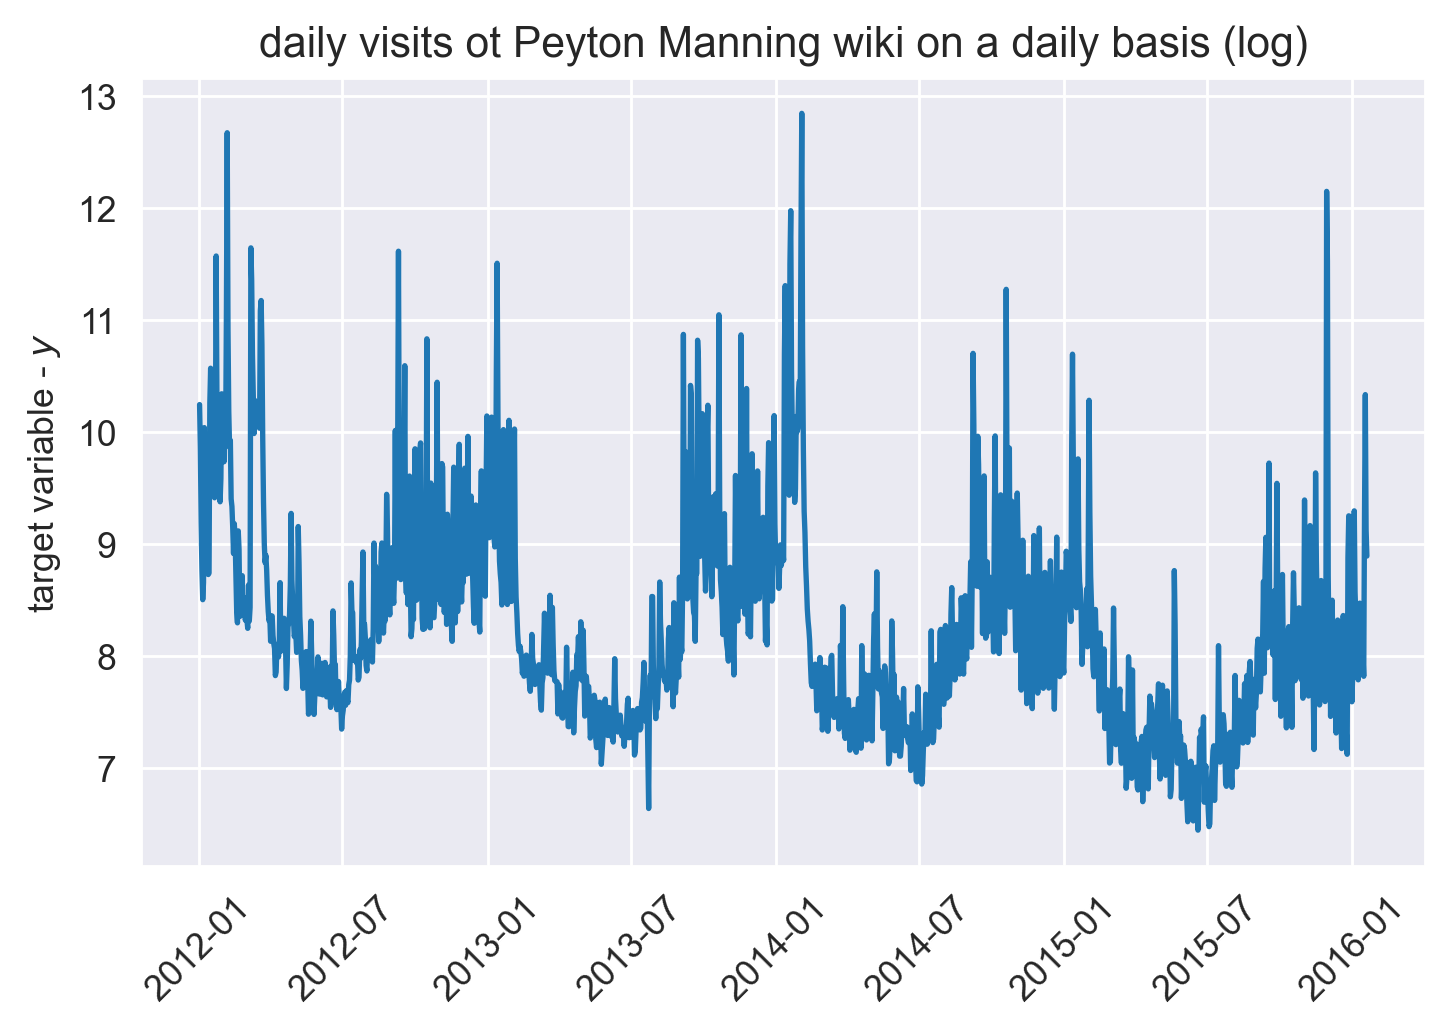

In [34]:
plt.plot_date(
    x=df_in["ds"],
    y=df_in["y"],
    label="input timeseries",
    fmt="-",
)
# plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("target variable - $y$")
plt.title("daily visits ot Peyton Manning wiki on a daily basis (log)")
plt.show()
# df_in.sample(n=5)

I have selected the data from 2012 onwards, for easy viewing. The first thing that i notice is that there is a dip around the 06, 07 months. Most likely the american football season (handegg?) is having its summer break then. also the same pattern repeates over the years start high then dips and then and high again. looks like there is some seaonality in the data. lets continue and train our first models. starting with a simple plain linear regression and then adding in the dummies to see if they improve the performance of the model.

## Train-test split

In [35]:
# train test split
df_train = df_in[(df_in["ds"] > "2012") & (df_in["ds"] < "2015")]
df_test = df_in[(df_in["ds"] > "2015")]

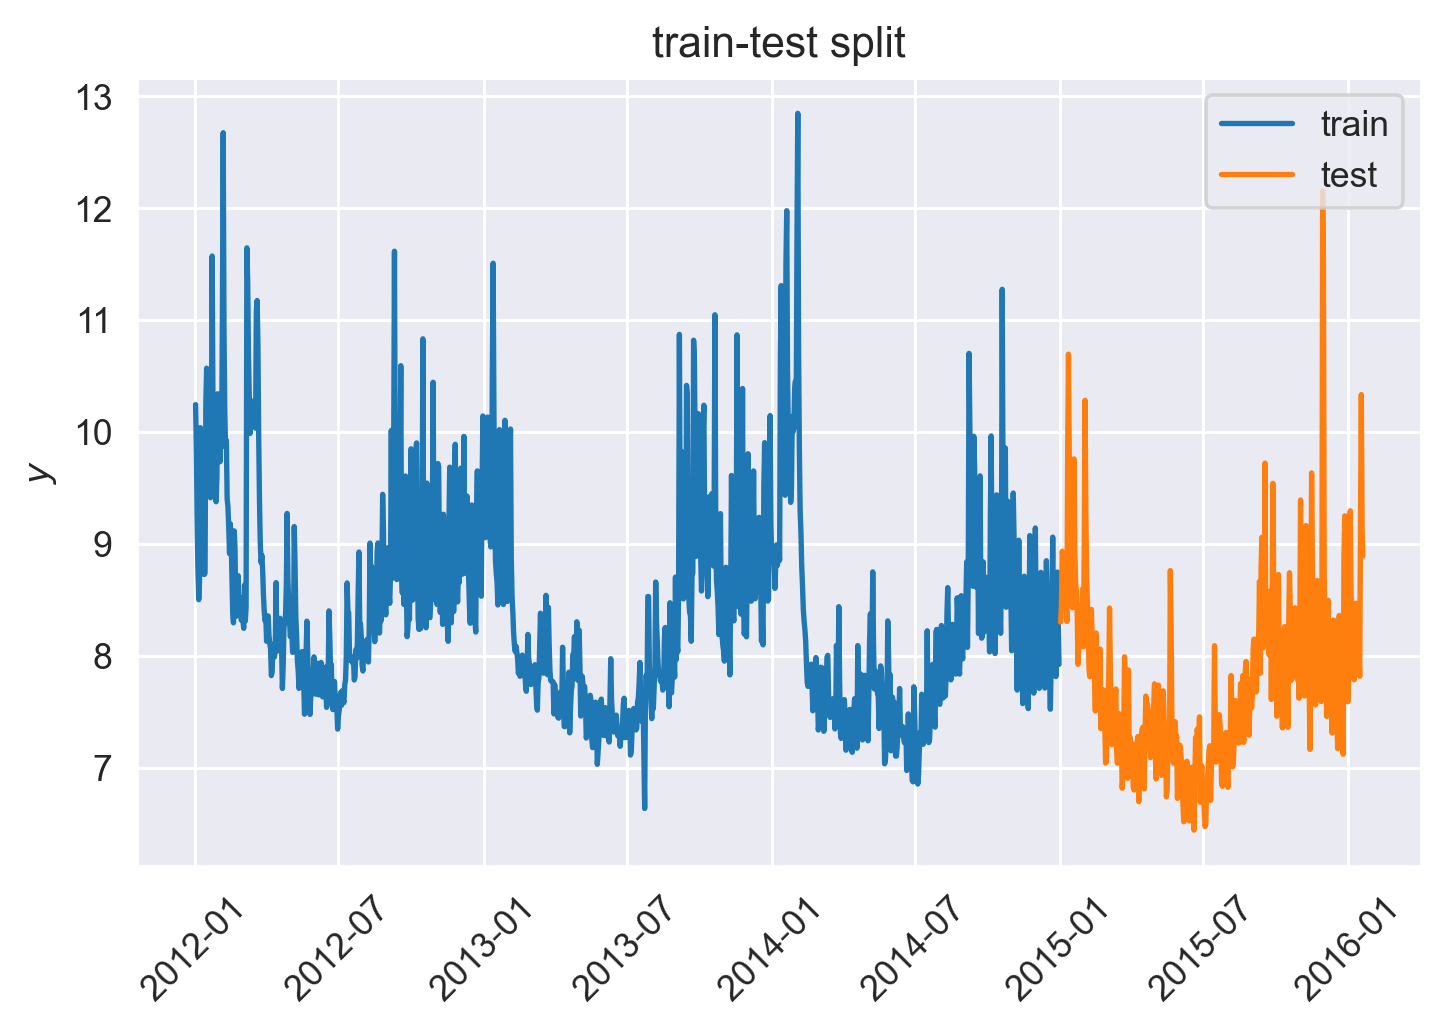

In [36]:
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)
plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title("train-test split")
plt.show()

## Setting up the regression

In [37]:
X_train = df_train["ds"].astype(int).values.reshape(-1, 1)
y_train = df_train["y"].values

X_test = df_test["ds"].astype(int).values.reshape(-1, 1)
y_test = df_test["y"].values

In [38]:
# creating, fit, and inference
linear = LinearRegression()
linear.fit(X=X_train, y=y_train)
y_pred = linear.predict(X=X_test)

In [39]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"mean squared error = {mse:.3}")
print(f"mean absolute error = {mae:.3}")

mean squared error = 0.617
mean absolute error = 0.615


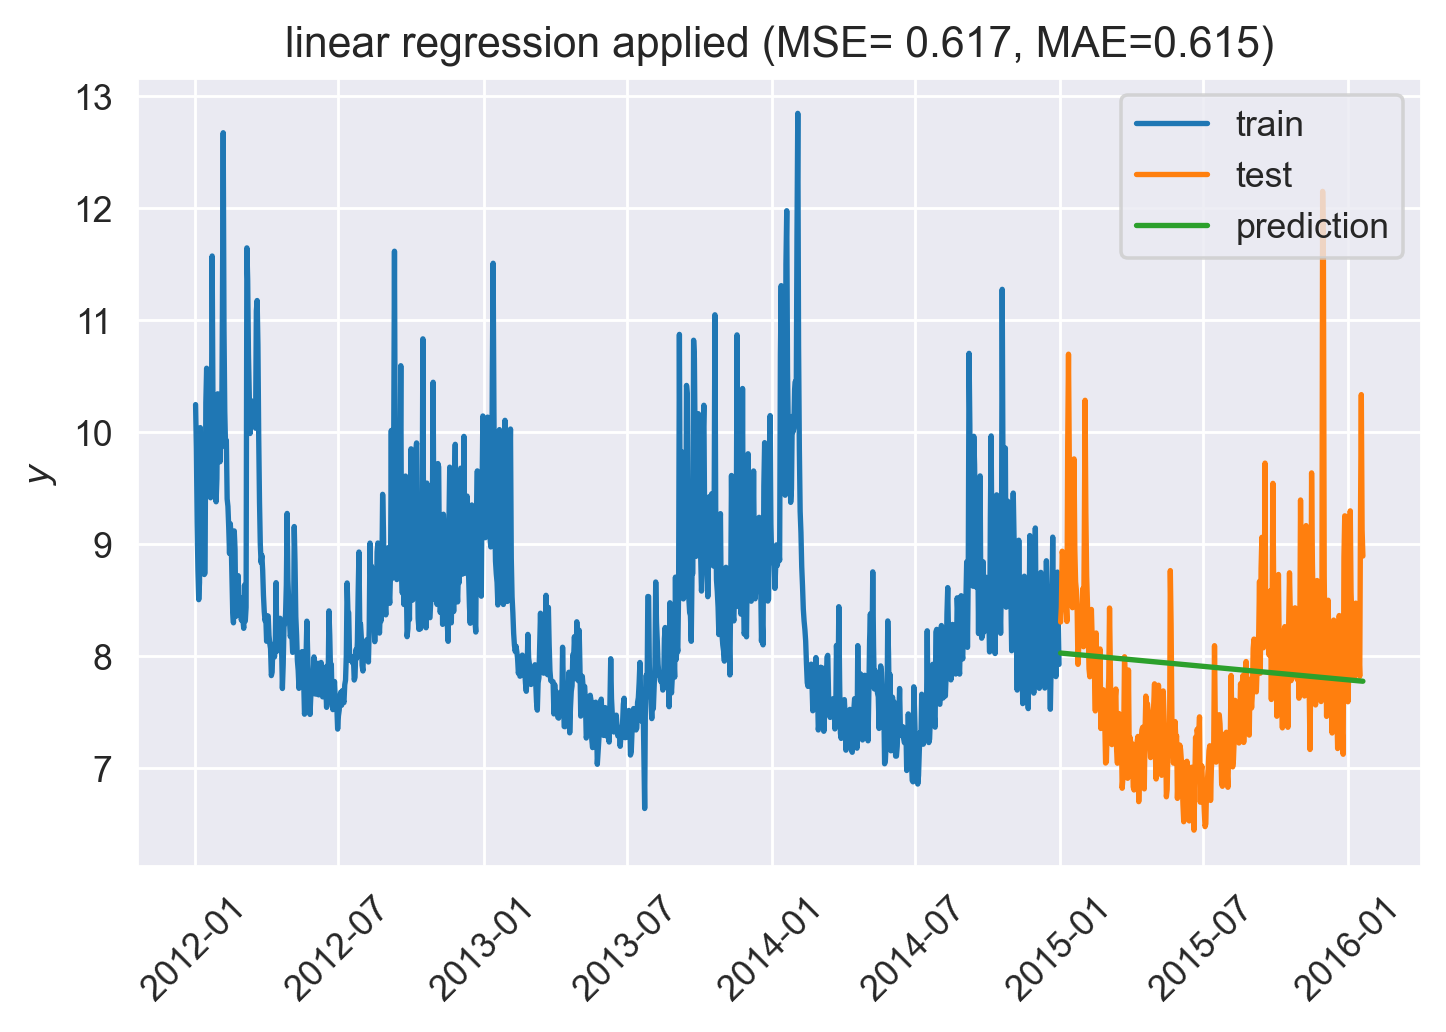

In [40]:
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred,
    label="prediction",
    fmt="-",
)

plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(f"linear regression applied (MSE= {mse:.3}, MAE={mae:.3})")
plt.show()

In [41]:
# creating dummies for the months
df_dummies = df_in.assign(
    month=df_in["ds"].dt.month.astype("category"), ds_int=df_in["ds"].astype(int)
)

not_dummy = {"y", "ds", "ds_int"}
to_dummy = set(df_dummies.columns) - not_dummy

df_dummies = pd.get_dummies(data=df_dummies, columns=["month"])
all_features = list(set(df_dummies.columns) - {"y", "ds"})

# slicing the input in train test
df_train_dummies = df_dummies[(df_dummies["ds"] > "2012") & (df_dummies["ds"] < "2015")]
df_test_dummies = df_dummies[(df_dummies["ds"] > "2015")]

X_train = df_train_dummies.loc[:, all_features]
y_train = df_train_dummies[["y"]]

X_test = df_test_dummies.loc[:, all_features]
y_test = df_test_dummies[["y"]]

In [42]:
df_dummies.drop(columns="ds_int").sample(n=5, random_state=1234567)

,ds,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1538,2012-04-18,8.335431,0,0,0,1,0,0,0,0,0,0,0,0
1647,2012-08-06,8.144389,0,0,0,0,0,0,0,1,0,0,0,0
2559,2015-02-08,7.812783,0,1,0,0,0,0,0,0,0,0,0,0
1904,2013-04-20,7.311886,0,0,0,1,0,0,0,0,0,0,0,0
2796,2015-10-03,7.459915,0,0,0,0,0,0,0,0,0,1,0,0


In [43]:
# create the pipeline
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X=X_train, y=y_train)
y_pred_dummies = pipeline.predict(X=X_test)

In [44]:
mse_dummies = mean_squared_error(y_test, y_pred_dummies)
mae_dummies = mean_absolute_error(y_test, y_pred_dummies)
print(f"mean squared error = {mse_dummies:.3}")
print(f"mean absolute error = {mae_dummies:.3}")

mean squared error = 0.326
mean absolute error = 0.397


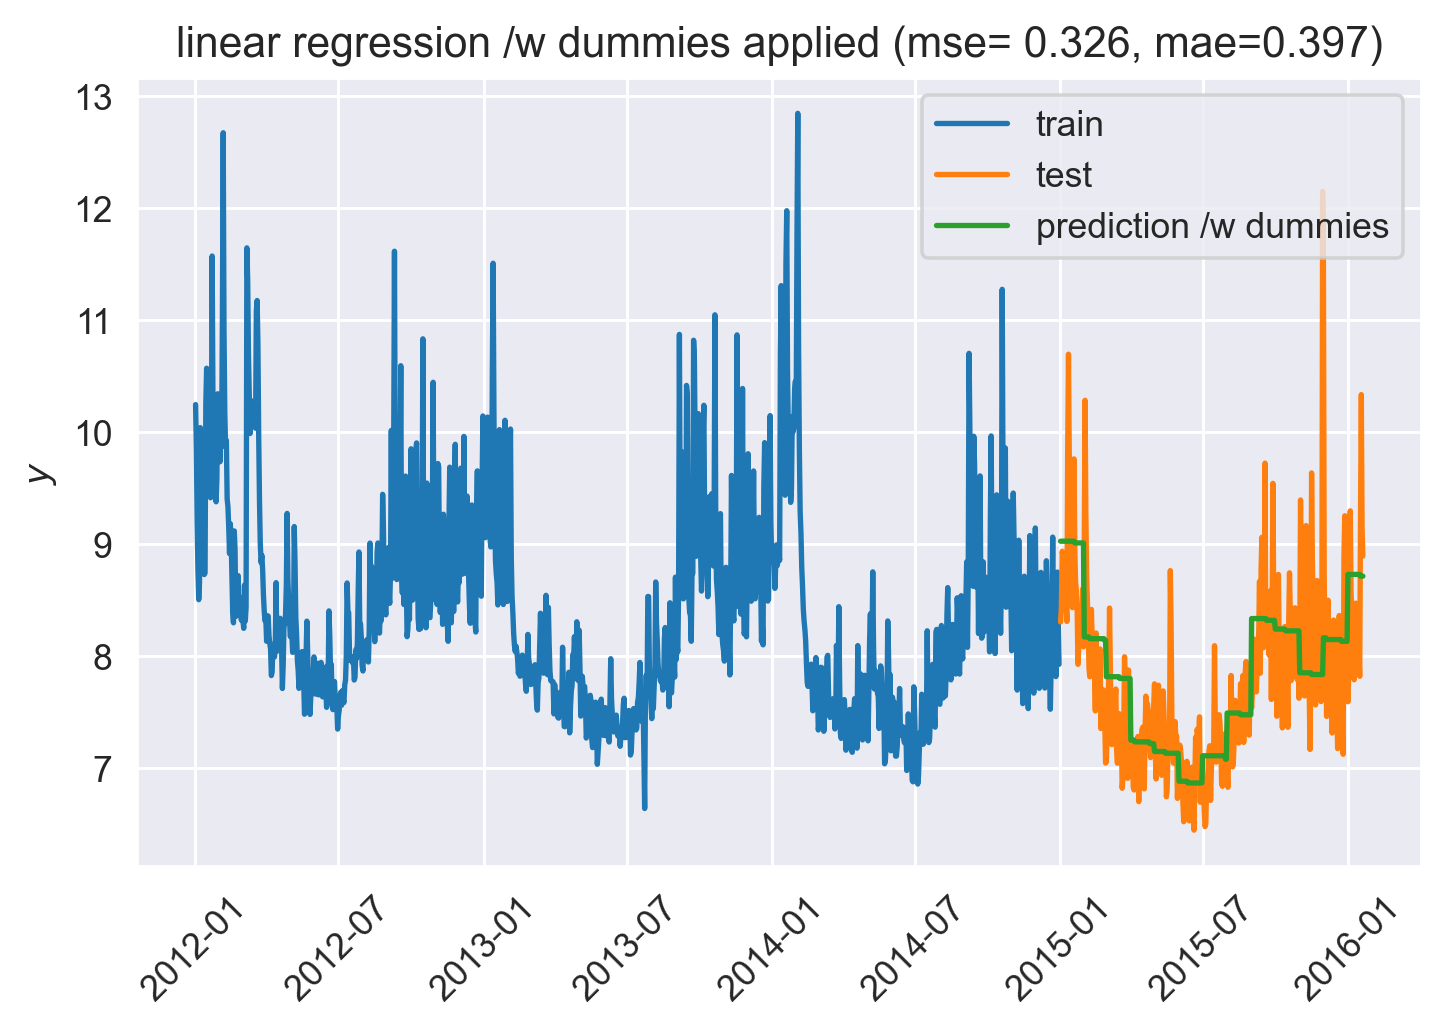

In [45]:
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred_dummies,
    label="prediction /w dummies",
    fmt="-",
)


plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(
    f"linear regression /w dummies applied (mse= {mse_dummies:.3}, mae={mae_dummies:.3})"
)
plt.show()

## Inspecting the seasonality

In [46]:
# pull coefs into a seperate df, to plot the influence of time
lin_reg_coefs = (
    pd.DataFrame(data=pipeline["linearregression"].coef_, columns=X_train.columns)
    .T.reset_index()
    .rename(columns={"index": "month", 0: "coefficient"})
)
# exclude the time col
lin_reg_coefs = lin_reg_coefs[lin_reg_coefs["month"] != "ds_int"]

# centering and scaling
lin_reg_coefs["coefficient"] = (
    lin_reg_coefs["coefficient"] - lin_reg_coefs["coefficient"].mean()
) / lin_reg_coefs["coefficient"].mean()

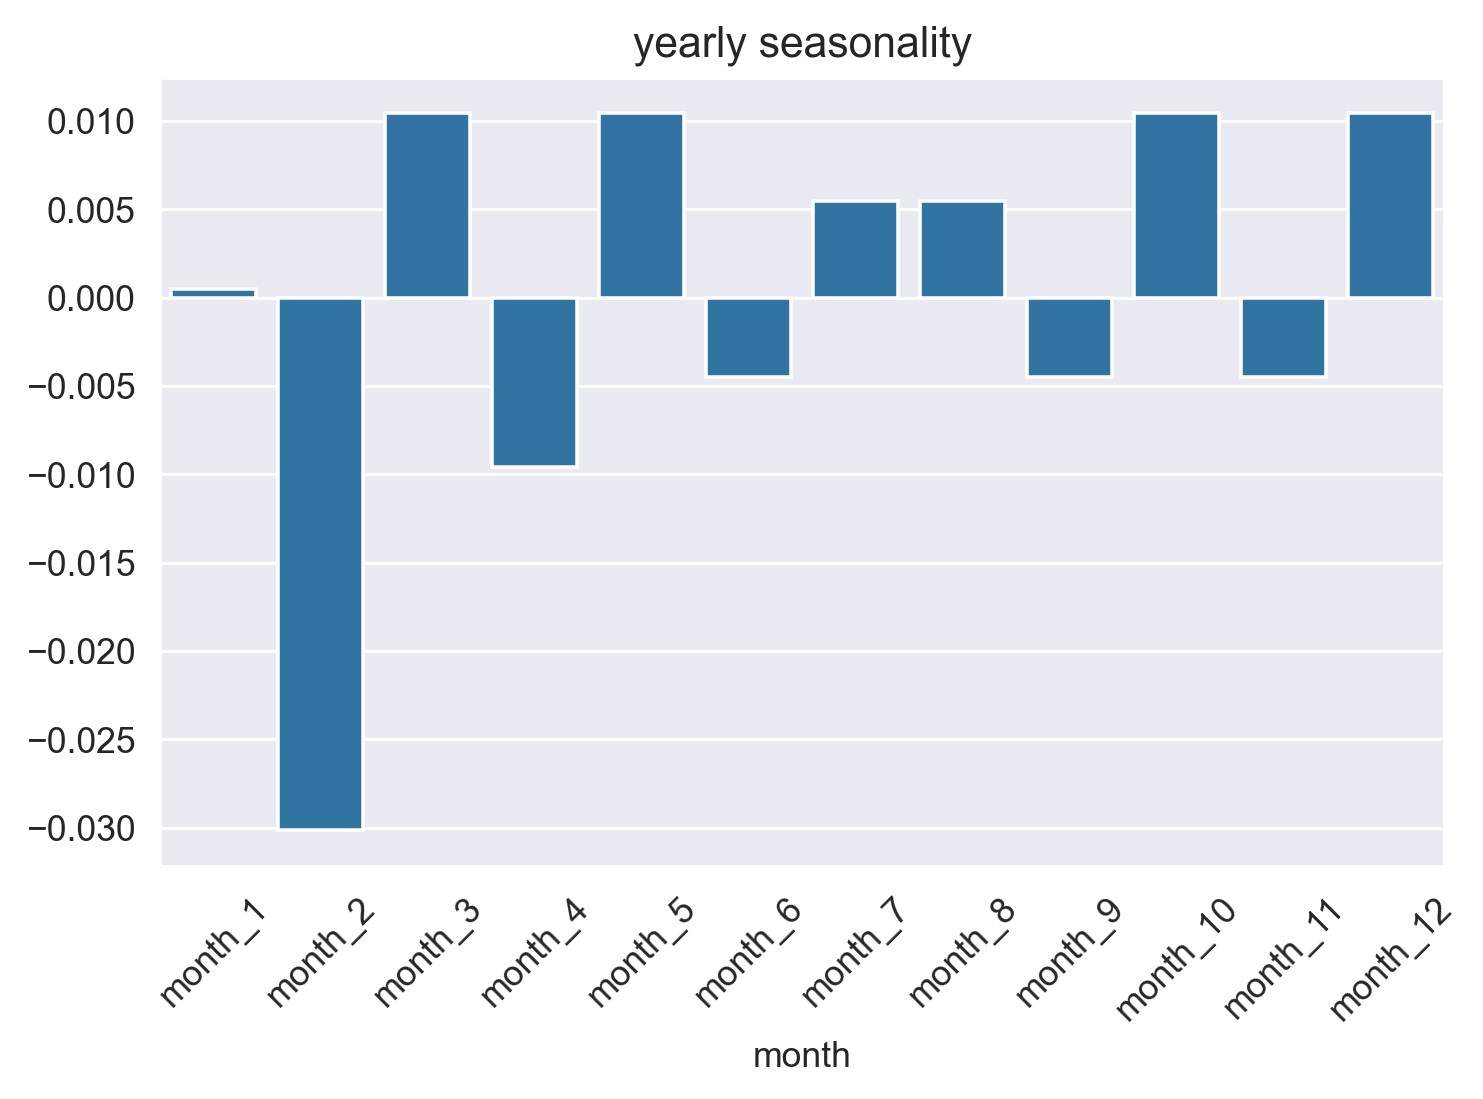

In [47]:
# | fig-cap: seasonality over the months aka yearly seasonality


chart = sns.barplot(
    data=lin_reg_coefs,
    x="month",
    y="coefficient",
    color=sns.color_palette()[0],
    order=[
        "month_1",
        "month_2",
        "month_3",
        "month_4",
        "month_5",
        "month_6",
        "month_7",
        "month_8",
        "month_9",
        "month_10",
        "month_11",
        "month_12",
    ],
)
plt.tick_params(axis="x", rotation=45)
plt.ylabel("")
plt.title("yearly seasonality")
plt.show()

In [48]:
# | echo: false
# | output: false
import gif

In [49]:
# | echo: false
# | output: false

# setting mpl params
fig_height = 2.0
fig_width = fig_height * 1.618
# plt.rcParams["figure.figsize"] = [fig_width, fig_height]
# plt.rcParams["figure.dpi"] = 100

with plt.rc_context({"figure.figsize": [fig_width, fig_height], "figure.dpi": 100}):

    # create on frame of the blend between linear and dummie regression lines
    @gif.frame
    def create_blend_gif(ratio):
        y_blend = (ratio * y_pred).reshape(-1, 1) + (1 - ratio) * y_pred_dummies
        with sns.axes_style("whitegrid"):
            plt.ylim(y_pred_dummies.min(), y_pred_dummies.max())
            plt.plot_date(
                x=df_test["ds"],
                y=y_blend,
                fmt="-",
            )
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # loop over all frames
    num_of_frames = 66
    gif_frames = [
        create_blend_gif(i) for i in np.linspace(start=0, stop=1, num=num_of_frames)
    ]

    # freeze on the bounce point
    gif_frames.extend([gif_frames[-1] for _ in range(num_of_frames // 6)])

    # add the the original series in reverse
    gif_frames.extend(gif_frames[::-1])

    # export the gif
    gif.save(
        gif_frames,
        "artifacts/ratio.gif",
        # duration=0.1, # seconds
    )